## Objetivos


*  Identificar el punto de vista del público con respecto a la vacuna Covid-19, aplicando un análisis de sentimiento al dataset.



## ¿Por qué utilizar Tweets?

Twitter es una plataforma que permite a sus usuarios expresar su opinión y participar en conversaciones públicas de forma libre y segura mediante el uso de *tweets*.

Esto nos puede permitir recopilar la opinión pública que no esté influenciada por medios o recursos externos que puedan afectar los resultados del análisis.

## Cargar Librerías

In [ ]:
!pip install vaderSentiment

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import spacy as sp
import re
import ast
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import io
import requests

## Exploración de la Data

### Cargar la Data

In [ ]:
#Cargar la data del CSV en un dataframe

data = 'https://raw.githubusercontent.com/ElianaArjona/summer-camp-ml/main/vaccination_tweets.csv'

df = pd.read_csv(data)
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [ ]:
#Mostrar las primeras 5 filas
df.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


### *Identificar Valores Nulos y su Distribución en la Data*

Es importante identificar si la data contiene valores nulos. Si es así, debemos identificar qué columnas contienen valores nulos y determinar el porcentaje que representan.

In [ ]:
# Obtener Nombre de las Columnas
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [ ]:
#Cantidad de filas en el dataframe 
len(df)

5898

In [ ]:
#Encontrar todos los valores nulos en el dataset
print("Total of null values", df.isna().sum().sum())

print("\n")

#Porcentaje de valores nulos en el dataset
print("Percent of null values", round(df.isna().sum().sum()*100/len(df),2),"%")

Total of null values 3075


Percent of null values 52.14 %


In [ ]:
#Encontrar todos los valores nulos por Columna
df.isna().sum()

id                     0
user_name              0
user_location       1222
user_description     375
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            1477
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

Ahora que hemos identificado las ocurrencias de los valores nulos, debemos decidir si eliminar estos datos o no. Antes de hacerlo, debemos comprender el posible efecto de eliminar estos datos.

Encontramos que el 52.2% de los datos son nulos, la distribución de estos valores nulos solo se encuentran en las columnas user_location, user_description y hashtags. 
Esto tiene sentido porque no todos comparten su ubicación con su dispositivo, o tienen una descripción sobre sí mismos o usan hashtags en sus tweets.

### Identificar la ubicación de los usuarios

Primero, vamos a identificar dónde se encuentran nuestros usuarios. 
La hipótesis es que están esparcidos por todo el mundo.

In [ ]:
#Cree un nuevo dataframe con solo los usuarios que tienen una ubicación específica

#Filtrar y Crear el Dataframe
df_location = df[df.user_location.notnull()]

#Verificar que el filtro funciona
df_location.isna().sum()

id                     0
user_name              0
user_location          0
user_description     168
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            1134
source                 0
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [ ]:
df_location.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False


Podemos ver que nuestras ubicaciones no están en un formato estándar, en la tercera fila es un usuario que puso "Your Bed" como su ubicación.

No hay una manera sencilla de formatear estos datos, pero veamos lo que hay dentro de la columna user_location.

In [ ]:
"""
Obtener nombres de ubicaciones únicas
Agruparlas por nombres y su frecuencia

"""

count_location = df_location.loc[df_location["user_location"].str.contains(","), "user_location" ].value_counts()

number_count =  count_location
names_count = count_location.index

for i in range(len(count_location)):
  print(names_count[i],"->",number_count[i])

London, England -> 84
Dubai, United Arab Emirates -> 47
Mumbai, India -> 37
GP Partner, Watford  -> 36
New Delhi, India -> 35
Toronto, Ontario -> 32
England, United Kingdom -> 30
London, UK -> 28
Chicago, IL -> 27
California, USA -> 24
Atlanta, GA -> 24
Miami, FL -> 20
Dublin City, Ireland -> 19
Cork, Ireland -> 19
North West, England -> 18
New York, NY -> 18
Weinheim, Germany -> 18
Houston, TX -> 17
South East, England -> 17
Los Angeles, CA -> 16
Chennai, India -> 16
Boston, MA -> 15
Philadelphia, PA -> 14
New York, USA -> 14
Michigan, USA -> 13
Washington, DC -> 12
Wales, United Kingdom -> 11
Dublin, Ireland -> 11
San Francisco, CA -> 11
Birmingham, England -> 10
Dallas, TX -> 10
Nottingham, England -> 10
Kuala Lumpur, Malaysia -> 9
South West, England -> 9
Texas, USA -> 9
Sydney, New South Wales -> 9
Istanbul, Turkey -> 9
Pretoria, South Africa -> 9
Manchester, England -> 9
Knokke,a spot in this Universe -> 9
Nashville, TN -> 8
Vermont, USA -> 8
Dubai, UAE -> 8
Vancouver, British Co

Definitivamente, con la descripción general de las ubicaciones de los usuarios, podemos inferir que los tweets se recopilaron de todo el mundo, lo que beneficia nuestro análisis porque no tenemos un sesgo por la ubicación.

Un sesgo de ubicación significaría que nuestro análisis se concentrará en ubicaciones específicas y no representará la opinión del público en todo el mundo.


In [ ]:
#Porcentaje de usuarios que tienen una ubicación específica en el dataset

print( "Porcentaje de usuarios con ubicacion ->", round(len(df_location.user_location.unique())*100/len(df),2) , "%")

Porcentaje de usuarios con ubicacion -> 30.4 %


#### *Nota*

Es cierto que esta columna está sucia, y que descartamos a los usuarios que no tienen una ubicación específica pero, como solo el 31,89% de ellos tiene la ubicación, no podemos decidir trabajar solo con usuarios que tenían ubicación.

Lo que podemos inferir sobre esta información es que los tweets se recopilaron de todo el mundo (no se aplicó ningún filtro de ubicación en la recopilación de datos), incluso si el usuario no tiene una ubicación, probablemente será aleatoria de todo el mundo.

### Explorando la columna 'source'

Veamos qué dispositivos utilizan con frecuencia los usuarios para twittear.

*Nota: solo hay un usuario que no tiene una fuente específica, por lo tanto, no tendrá impacto en nuestro análisis*

In [ ]:
#Obteniendo vistas sin procesar sobre los dispositivos utilizados
df['source'].unique()

array(['Twitter for Android', 'Twitter Web App', 'Twitter for iPhone',
       'TweetDeck', 'Buffer', 'Twitter for iPad', 'Twitter Media Studio',
       'ThreadReaderApp', 'Instagram', 'SocialFlow', 'Hootsuite Inc.',
       'LinkedIn', 'Twitter for Mac', '24liveblog', 'Publer ', 'IFTTT',
       'Socialbakers', 'Falcon Social Media Management ', 'Echobox',
       'Microsoft Power Platform', 'Nonli', 'Sendible', nan, 'EastMojo',
       'Twitter Media Studio - LiveCut', 'Tweetbot for Mac', 'GT_Backend',
       'SocialNewsDesk', 'Sprout Social', 'TweetCaster for Android',
       'UberSocial for Android', 'Blog2Social APP', 'WordPress.com',
       'Paper.li', 'News Users', 'ETRetail.com', 'Tweetbot for iΟS',
       'Sprinklr Publishing', 'Hocalwire Social Share', 'CoSchedule'],
      dtype=object)

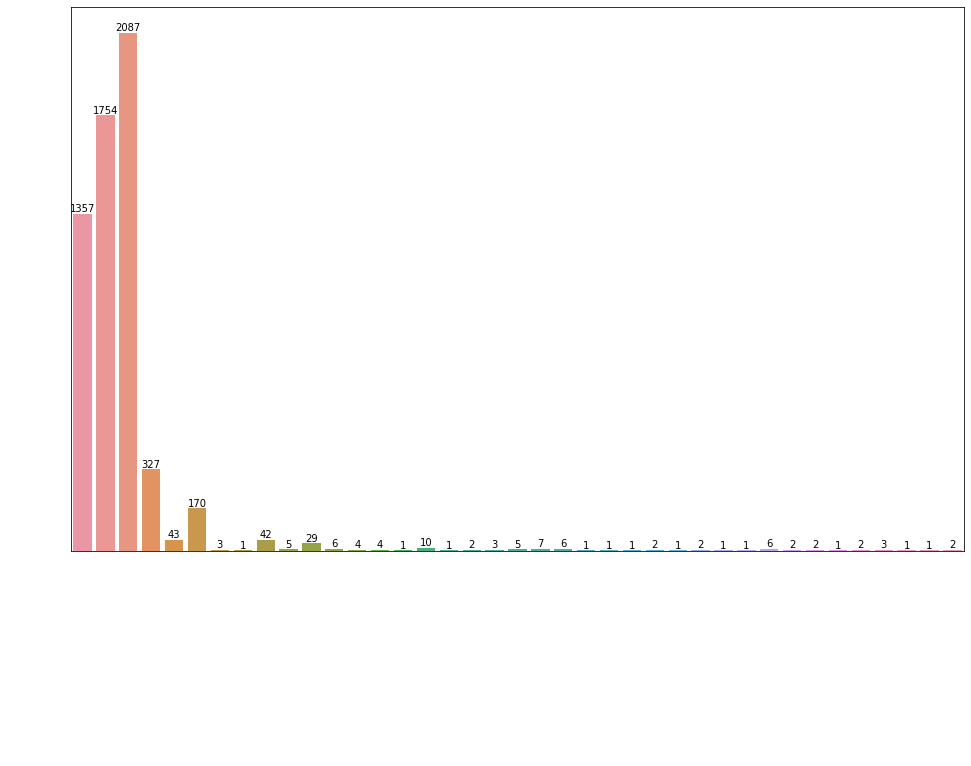

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.countplot(x='source',data= df.loc[df['source'].notna()] )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for p in ax.patches:
    ax.annotate(   p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points'
                )

    ax.tick_params(axis='x', colors='white',size=16)
    ax.tick_params(axis='y', colors='white',size=16)
    
    ax.xaxis.label.set_color('white')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_color('white')
    ax.yaxis.label.set_size(16)
   
    
plt.show()

Dipositivos más Utilizados:


1.   Twitter for Android
2.   Twitter Web App
3.   Twitter or iPhone


Esta es una buena información para conocer, pero no es relevante para nuestro análisis.

Estos datos podrían ser útiles si nuestro análisis se centrara en una campaña de marketing basada en la participación del usuario, por ejemplo.

### Explorando la columna 'hashtags'

Como sabemos que los hastags se utilizan para filtrar el contenido de un tweet, los hastags utilizados deben ser sobre el contenido del tweet, por lo que, si un usuario desea obtener solo los datos sobre covid, puede buscar los hastatgs relacionados con este tema.

In [ ]:
print( "Porcentaje de valores nulos en la columna hashtags ->",round(len(df['hashtags'].loc[df['hashtags'].isnull()])*100/len(df),2), "%" )

Porcentaje de valores nulos en la columna hashtags -> 25.04 %


Dentro de nuestro dataset, existen algunos valores nulos en las columnas de los hashtags. Su porcentaje es solo del 25.86%, incluso si el tweet no tiene hashtags, el contenido del texto sigue siendo relevante para nuestro análisis.

In [ ]:
#Obtener todos hashtags

df_tags = df[df['hashtags'].notna()]

In [ ]:
#Conar y agrupar los hastags

count_tags = df_tags["hashtags" ].value_counts()
count_tags[:30]

['PfizerBioNTech']                              703
['PfizerBioNTech', 'CovidVaccine']               79
['PfizerBiontech']                               66
['COVID19']                                      58
['PfizerBioNTech', 'vaccine']                    55
['CovidVaccine']                                 52
['PfizerBioNTech', 'COVID19']                    45
['CovidVaccine', 'PfizerBioNTech']               42
['vaccine']                                      28
['COVID19', 'PfizerBioNTech']                    26
['PfizerBioNtech']                               26
['PfizerBioNTech', 'Moderna']                    26
['Pfizer']                                       25
['EU', 'Covid19', 'covidvaccines', 'Pfizer']     19
['PfizerVaccine']                                18
['PfizerBioNTech', 'COVID19Vaccine']             16
['PfizerBioNTech', 'vaccines']                   16
['Iran', 'PfizerBioNTech', 'COVIDvaccines']      15
['Iran', 'PfizerBioNTech', 'vaccines']           14
['Iran', 'Co

Podemos ver que en este conjunto de datos los hashtags están relacionados con la vacuna contra el Covid o Covid-19 en general. Significa que estos datos están limpios y no hay tweets relacionados con otro tema que no sea el Covid-19.

# Limpieza de Datos

Para los propósitos de este análisis, solo usaremos 2 columnas. 
Se consideró que estos eran los más relevantes:


*   Text
*   Hashtags

Para la limpieza de datos, crearemos dos (2) funciones que eliminarán tanto los hashtags como los enlaces del texto del tweet.


In [ ]:
print(df.loc[2,"text"])
print(df.loc[2,"hashtags"])


#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']


Como podemos ver en este ejemplo, algunos textos de tweets tienen hashtags dentro de su contenido. Con el fin de obtener el sentimiento del tweet, necesitamos limpiar los datos eliminando los enlaces y el carácter "#" de los textos.

### Eliminar Hashtags y Enlances

In [ ]:
def remove_hastags_links(tags,text):

  string  =  text.split()
  temporal = text.split()

  #Rmeove links
  for word in string:
    if "http" in word or "@" in word:
      temporal.remove(word)


  text = " ".join(temporal)

  #Remove Tags
  text = text.replace("#","")



  return text.strip()

# remove_hastags_links("['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",
#                      "#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P")

In [ ]:
#Apply the function to all teh data inside the column text
for i in range(len(df['text'])):
  tags =  df.loc[i,'hashtags']
  text =  df.loc[i,'text']
  df.loc[i,"text"] = remove_hastags_links(tags,text)

In [ ]:
df[['text','hashtags']]

,text,hashtags
0,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech']
1,While the world has been on the wrong side of ...,NaN
2,coronavirus SputnikV AstraZeneca PfizerBioNTec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf..."
3,"Facts are immutable, Senator, even when you're...",NaN
4,Explain to me again why we need a vaccine wher...,"['whereareallthesickpeople', 'PfizerBioNTech']"
...,...,...
5893,I had a little soreness at injection site afte...,"['vaccinated', 'PfizerBiontech']"
5894,Had the PfizerBiontech COVIDVaccine today in n...,"['PfizerBiontech', 'COVIDVaccine', 'northtynes..."
5895,Can’t wait to get vaccinated so I can tell my ...,"['Covid_19', 'PfizerBiontech']"
5896,Valentine's day gift anybody? ValentinesDay Pf...,"['ValentinesDay', 'PfizerBiontech', 'vaccine']"


En este ejemplo podemos ver que efectivamente eliminamos los enlaces y el carácter "#".

#### Valores de 'text' vacíos

La clave en nuestro análisis es obtener el sentimiento del texto pero, a veces, "" un carácter vacío se ve como una cadena en el dataframe, por lo tanto, no lo identificará como un valor nulo.

Averigüemos si este es el caso en nuestro dataset

In [ ]:
df[df.text == ''].head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
334,1338969528395558916,Simon Hodes ⬅️2m➡️ 😷,"GP Partner, Watford",NHS GP #Chronoptimist LMC Rep #TeamGP💙Trainer ...,2014-07-28 13:32:12,1973,2435,19123,False,2020-12-15 22:09:47,,NaN,Twitter for Android,0,1,False
1691,1343548603361619972,Alexandra,Italy,I am Biologiste and Nutritionist . Human Right...,2009-10-23 09:59:07,1270,593,135646,False,2020-12-28 13:25:23,,NaN,Twitter for Android,3,2,False
1788,1343725728408494080,"Dana Lukin MD, PhD","New York, USA","Clinical Director of Translational Research, J...",2015-12-10 22:54:42,1157,280,5835,False,2020-12-29 01:09:13,,NaN,Twitter Web App,1,4,False
1851,1344253118410678272,Bhartiya,India,A Proud Indian,2018-03-08 07:36:09,269,335,188904,False,2020-12-30 12:04:53,,NaN,Twitter for Android,0,1,False
1864,1344225831892226051,VOICE OF THUNDER,"New York, USA",Have you an arm like God?\nOr can you thunder ...,2012-11-28 14:12:04,318,926,381,False,2020-12-30 10:16:27,,NaN,Twitter for Android,0,0,False


¡BINGO! Encontramos cadenas vacías en la columna de texto del tweet. ¡Esto es malo, así que debemos deshacernos de esto!

In [ ]:
print(len(df[df.text == '']))

17


In [ ]:
df.isna().sum()

id                     0
user_name              0
user_location       1222
user_description     375
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            1477
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

Por suerte, solo hay 15 filas con este caso, las eliminaremos.

In [ ]:
#Eliminando las filas que cumplen con la condición
df.drop(df[df.text == ''].index, inplace=True)
df.reset_index(inplace=True)
print("index reset into new order")

index reset into new order


In [ ]:
print(len(df[df.text == '']))

0


# Procesamiento de Datos

### Análisis de Sentimiento aplicando VADER

Para el análisis de sentimiento, usaremos Vader() debido que ha demostrado tener muy buenos resultados trabajando con data de redes sociales.

Es capaz de interpretar emojis, signos de puntuación, texto, jergas y otras cosas.

In [ ]:
#Cargando el objeto VADER
analyser = SentimentIntensityAnalyzer()

Ejemplo del Vader Sentiment

In [ ]:
print("Very good movie :) ->", analyser.polarity_scores("Very good movie :)") )
print("Very bad movie :() ->",analyser.polarity_scores("Very bad movie :(") )

Very good movie :) -> {'neg': 0.0, 'neu': 0.236, 'pos': 0.764, 'compound': 0.7548}
Very bad movie :() -> {'neg': 0.777, 'neu': 0.223, 'pos': 0.0, 'compound': -0.788}


Esta es la salida que nos dio VADER. Vamos a trabajar con el método de *polarity_scores*, como se muestra en el ejemplo.

#### Agregar columna de puntuación y clasificación de sentimiento

Primero, debemos clasificar nuestro texto como positivo, negativo o neutral.

Vamos a crear una función que tome la puntuación más alta entre estas clases y la asignaremos a nuevas columnas en nuestro dataframe, que llamaremos "score" (puntuación).

In [ ]:
#deciding threshold
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)

    if score['neu'] > score['pos'] and score['neu'] > score['neg'] :
      return [score['neu'],"neutral"]
    
    elif score['pos'] >= score['neu'] and score['pos'] > score['neg']:
      return [score['pos'],"positive"]
    
    elif score['neg'] >= score['neu'] and score['neg'] > score['pos']:
      return [score['neg'], "negative"]


   
#Create new columns score and sentiment
df['score'] = None
df['sentiment'] = None

list_scores,list_sentiment,data = [],[],[]


#Assign the respective score value to our new columns
for i in range( len(df['text']) ):
  text =  df.loc[i,'text']
  data = sentiment_analyzer_scores(text)
  list_scores.append(data[0])
  list_sentiment.append(data[1])

df['score'] = list_scores
df['sentiment'] = list_sentiment


In [ ]:
#Mostrar Resultados

df[['text','hashtags', 'score','sentiment']]

,text,hashtags,score,sentiment
0,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0.787,neutral
1,While the world has been on the wrong side of ...,NaN,0.756,neutral
2,coronavirus SputnikV AstraZeneca PfizerBioNTec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0.867,neutral
3,"Facts are immutable, Senator, even when you're...",NaN,1.000,neutral
4,Explain to me again why we need a vaccine wher...,"['whereareallthesickpeople', 'PfizerBioNTech']",1.000,neutral
...,...,...,...,...
5876,I had a little soreness at injection site afte...,"['vaccinated', 'PfizerBiontech']",1.000,neutral
5877,Had the PfizerBiontech COVIDVaccine today in n...,"['PfizerBiontech', 'COVIDVaccine', 'northtynes...",0.728,neutral
5878,Can’t wait to get vaccinated so I can tell my ...,"['Covid_19', 'PfizerBiontech']",1.000,neutral
5879,Valentine's day gift anybody? ValentinesDay Pf...,"['ValentinesDay', 'PfizerBiontech', 'vaccine']",0.674,neutral


#### Visualización de Resultados

In [ ]:
df.sentiment.value_counts()

neutral     5817
positive      48
negative      16
Name: sentiment, dtype: int64

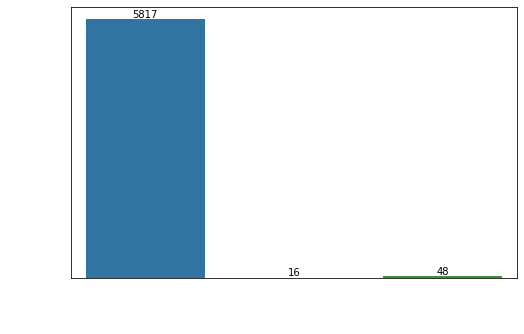

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='sentiment',data=df)

for p in ax.patches:
    ax.annotate(   p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points'
                )
    
    ax.tick_params(axis='x', colors='white',size=16)
    ax.tick_params(axis='y', colors='white',size=16)
    
    ax.xaxis.label.set_color('white')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_color('white')
    ax.yaxis.label.set_size(16)
   
    
plt.show()

Veamos más de cerca a los comentarios positivos y negativos.

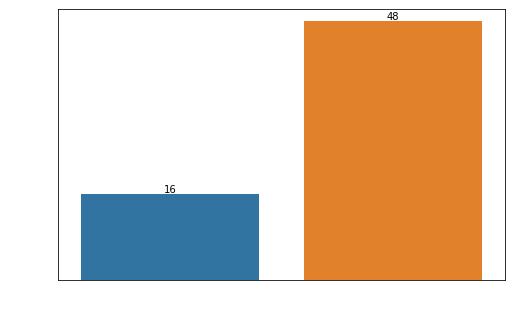

In [ ]:
df_sentiment = df[df['sentiment']!='neutral']

plt.figure(figsize=(8,5))
ax = sns.countplot(x='sentiment',data=df_sentiment)

for p in ax.patches:
    ax.annotate(   p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points'
                )
    
    ax.tick_params(axis='x', colors='white',size=16)
    ax.tick_params(axis='y', colors='white',size=16)
    
    ax.xaxis.label.set_color('white')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_color('white')
    ax.yaxis.label.set_size(16)
   
    
plt.show()

####  Nota

Es importante observar que:


*   La cantidad de valores negativos y positivos es demasiado pequeño en comparación con nuestros comentarios neutrales.
*   Hay más comentarios positivos sobre la vacuna covid que negativos, debemos verificar esto comprobando la frecuencia de las palabras.



#### Word Cloud 

##### Positivos

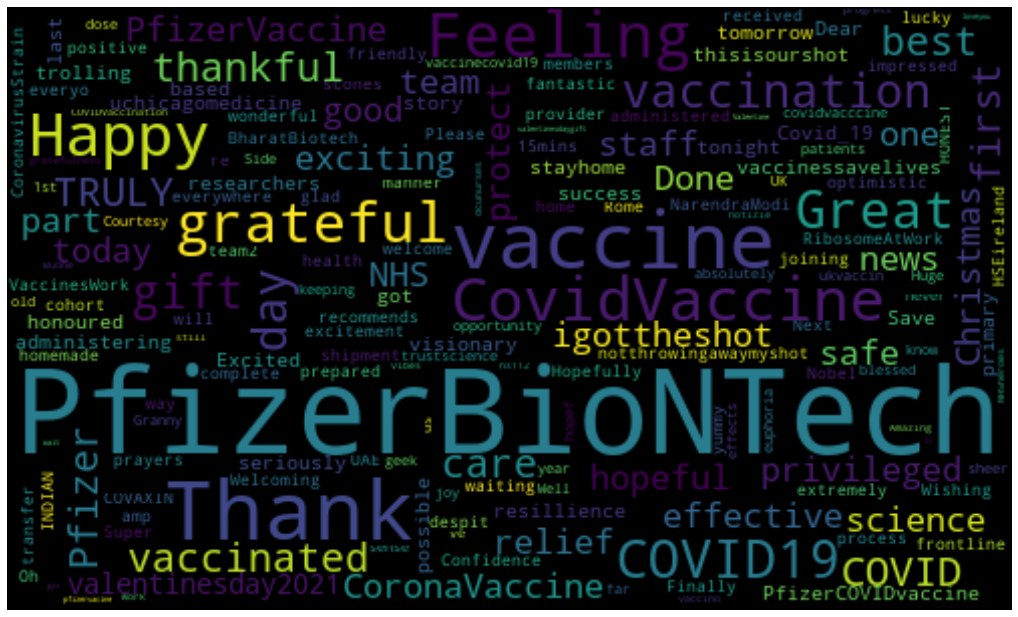

In [ ]:
# Word cloud visualization

df_pos = df[df['sentiment']=='positive']

from wordcloud import WordCloud


allWords = ' '.join([twts for twts in df_pos['text']])

wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (18,18))

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Aquí podemos ver que los tweets positivos contienen palabras como: 'happy', 'effective', 'good', 'grateful', la cual es un resultado esperado.

##### Negativos

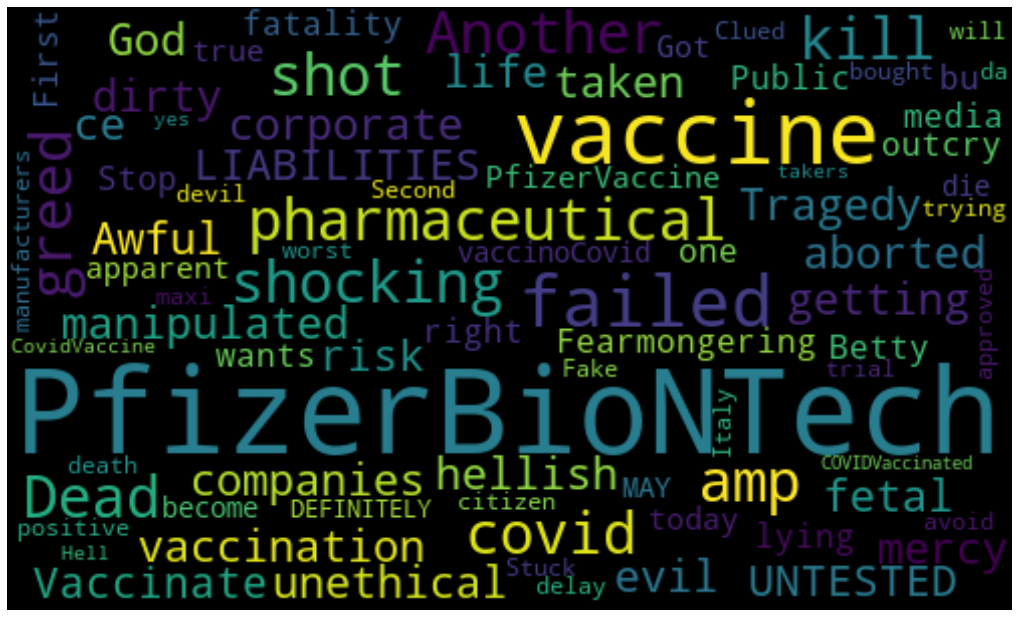

In [ ]:
# Word cloud visualization

df_neg = df[df['sentiment']=='negative']

from wordcloud import WordCloud

allWords = ' '.join([twts for twts in df_neg['text']])

wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (18,18))

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Aquí podemos ver que los tweets negativos contienen palabras como: 'dead', 'shocking', 'devil', 'awful', 'greed', 'unethical', lo cual es un resultado esperado.

### Remover Hashtags

Otro enfoque que podríamos probar es eliminar el texto del hashtag de los comentarios.

Tal vez podríamos obtener un mejor resultado al tratar de evitar palabras neutrales de uso común como coronavirus, covid-19 o cualquiera de los nombres de las vacunas.

In [ ]:
data = 'https://raw.githubusercontent.com/ElianaArjona/summer-camp-ml/main/vaccination_tweets.csv'
df_no_tags = pd.read_csv(data)

df_no_tags.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [ ]:
def remove_hastags(tags,text):

  string  =  text.split()
  temporal = text.split()

  # Remove link 
  for word in string:
    if "http" in word or "@" in word:
      temporal.remove(word)


  text = " ".join(temporal)

  #Remove Tags
  try :
    tags = ast.literal_eval(tags)
    for tag in tags:
       if tag in text:
         remove = "#"+tag
         text = text.replace(remove,"") 
  except:
    pass

  return text.strip()

# remove_hastags("['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",
#                      "#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P")

In [ ]:
#Remove the hashtags out of the text
for i in range(len(df_no_tags['text'])):
  tags =  df_no_tags.loc[i,'hashtags']
  text =  df_no_tags.loc[i,'text']
  df_no_tags.loc[i,"text"] = remove_hastags(tags,text)

In [ ]:
df_no_tags[['text','hashtags']]

,text,hashtags
0,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech']
1,While the world has been on the wrong side of ...,NaN
2,Russian vaccine is created to last 2-4 years…,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf..."
3,"Facts are immutable, Senator, even when you're...",NaN
4,Explain to me again why we need a vaccine …,"['whereareallthesickpeople', 'PfizerBioNTech']"
...,...,...
5893,I had a little soreness at injection site afte...,"['vaccinated', 'PfizerBiontech']"
5894,Had the today in and feeling ok. Smooth ope...,"['PfizerBiontech', 'COVIDVaccine', 'northtynes..."
5895,Can’t wait to get vaccinated so I can tell my ...,"['Covid_19', 'PfizerBiontech']"
5896,Valentine's day gift anybody?,"['ValentinesDay', 'PfizerBiontech', 'vaccine']"


In [ ]:
#Drop rows that meet the condition
df_no_tags.drop(df_no_tags[df_no_tags.text == ''].index, inplace=True)
df_no_tags.reset_index(inplace=True)
print("index reset into new order")


index reset into new order


#### Agregar las columnas de 'score' y 'sentiment'

In [ ]:
#User the same function as before

df_no_tags['score'] = None
df_no_tags['sentiment'] = None

list_scores, list_sentiment = [],[]

for i in range( len(df_no_tags['text']) ):
  text =  df_no_tags.loc[i,'text']
  data = sentiment_analyzer_scores(text)
  list_scores.append(data[0])
  list_sentiment.append(data[1])

df_no_tags['score'] = list_scores
df_no_tags['sentiment'] =list_sentiment


#### Word Cloud

##### Positivos

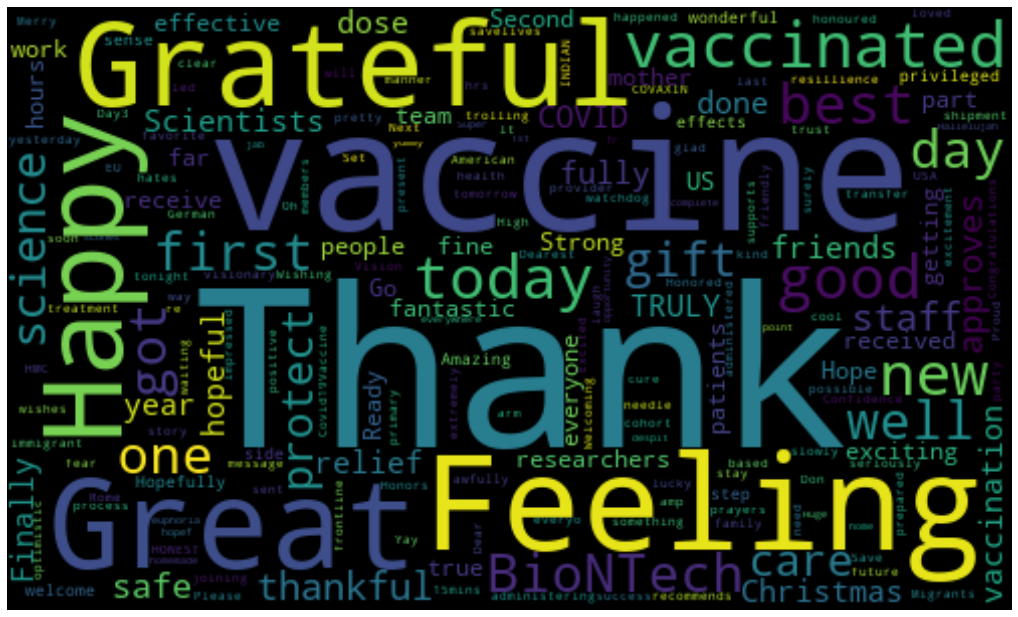

In [ ]:
# Word cloud visualization

df_pos_no_tags = df_no_tags[df_no_tags['sentiment']=='positive']

from wordcloud import WordCloud

allWords = ' '.join([twts for twts in df_pos_no_tags['text']])

wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (18,18))

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Estas palabras ya se ven mejor para nuestro recuento de palabras positivas, podemos ver palabras más significativas en lugar de los nombres de la vacuna.

##### Negativas

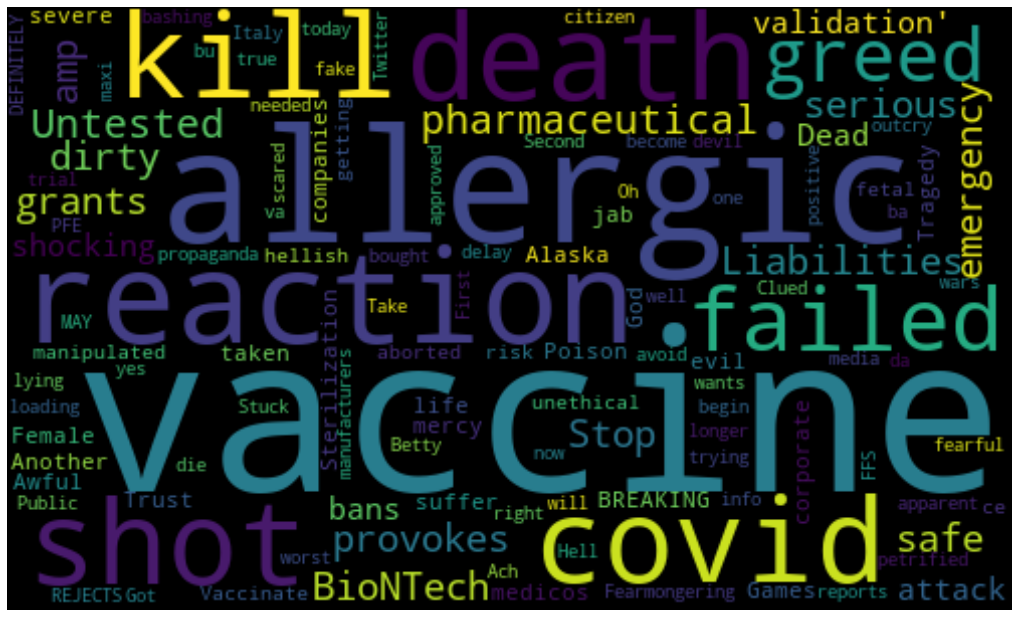

In [ ]:
# Word cloud visualization

df_neg_no_tags = df_no_tags[df_no_tags['sentiment']=='negative']

from wordcloud import WordCloud

allWords = ' '.join([twts for twts in df_neg_no_tags['text']])

wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (18,18))

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Lo mismo ocurre aquí con las palabras negativas.

### Explorando Valores Neutrales

Estas palabras son interesantes, pero la cantidad de tweets analizados es demasiado pequeña en comparación con nuestro dataset.
Podríamos intentar solucionar esto disminuyendo la cantidad de comentarios neutrales estableciendo un *threshold* que podríamos usar como punto de referencia para identificar si el comentario es positivo o negativo.

Para establecer un *threshold*, necesitamos probar qué tan neutrales son los comentarios que tienen una puntuación de 0.9 de neutral, 0.8, 0.7 ... disminuyendo el *threshold* hasta encontrar uno con el que podamos trabajar.

In [ ]:
threshold = 0.65

In [ ]:
df_user_neu_filter = df_no_tags.loc[ (df_no_tags['score'] < threshold) & (df_no_tags['score'] > 0) ].reset_index()

print(len(df_user_neu_filter))

711


Utilizamos el dataframe sin hashtags porque ya que vimos que produce mejores resultados al eliminar los hashtags del comentario.

In [ ]:
for i in range(50):
  print( sentiment_analyzer_scores( df_user_neu_filter.loc[i,'text']) ,
        "->", df_user_neu_filter.loc[i,'text']
       )
  print("\n")

[0.637, 'neutral'] -> it is a bit sad to claim the fame for success of  on patriotic competition between USA, Canada, UK and…


[0.569, 'neutral'] -> There have not been many bright days in 2020 but here are some of the best 1.  winning …


[0.516, 'neutral'] -> The trump administration failed to deliver on vaccine promises, *shocker*   …


[0.639, 'neutral'] -> approval Apprentice Style! “Approve the  or you…


[0.634, 'neutral'] -> Interesting and very detailed article showing up how a well tested , with  will help d…


[0.622, 'neutral'] -> Please don’t spread fake news! There is no evidence that these cases are linked to the…


[0.606, 'neutral'] -> authorizes   vaccine for emergency use


[0.535, 'negative'] -> Tragedy. Another life taken by corporate greed and the evil pharmaceutical companies.  …


[0.633, 'neutral'] -> Such a great feeling. A big thank you to all the healthcare professionals; scientists, nurses, doctors, caregivers.…


[0.532, 'negative'] -> = Female Sterilizat

0.65 Parece ser un buen *threshold*, el comentario tiende a tener un significado ligeramente positivo o negativo con el que podemos trabajar.

## Valores Neutrales

Vamos a cambiar el sentimiento y la puntuación en esas filas que podemos reclasificar

In [ ]:
def sentiment_analyzer_fixed_scores(sentence):
    score = analyser.polarity_scores(sentence)

    if score['neu'] > threshold or score['neg'] == score['pos'] :
      return [score['neu'],"neutral"] 

    elif score['pos'] > score['neg']:
      return [score['pos'],"positive"]

    elif  score['neg'] > score['pos']:
      return [score['neg'],"negative"]
    

In [ ]:
df_no_tags['sentiment'] = None
df_no_tags['score'] = None

list_sentiment,list_scores = [],[]

for i in range( len(df_no_tags['text']) ):
  text =  df_no_tags.loc[i,'text']
  data = sentiment_analyzer_fixed_scores(text)

  list_scores.append(data[0])
  list_sentiment.append(data[1])

df_no_tags['score'] = list_scores
df_no_tags['sentiment'] =list_sentiment

In [ ]:
df_no_tags.sentiment.value_counts()

neutral     5123
positive     574
negative     184
Name: sentiment, dtype: int64

Podemos ver que nuestra muestra es un poco más significativa ahora, no es tan significativa como queríamos, pero ahora evaluaremos más comentarios y tal vez obtengamos una perspectiva diferente sobre el dataset.

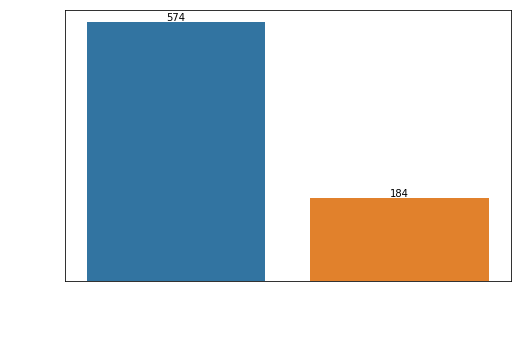

In [ ]:
df_sentiment = df_no_tags[df_no_tags['sentiment']!='neutral']

plt.figure(figsize=(8,5))
ax = sns.countplot(x='sentiment',data=df_sentiment)

for p in ax.patches:
    ax.annotate(   p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points'
                )
    
    ax.tick_params(axis='x', colors='white',size=16)
    ax.tick_params(axis='y', colors='white',size=16)
    
    ax.xaxis.label.set_color('white')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_color('white')
    ax.yaxis.label.set_size(16)
   
    
plt.show()

### Word Cloud

#### Positiva

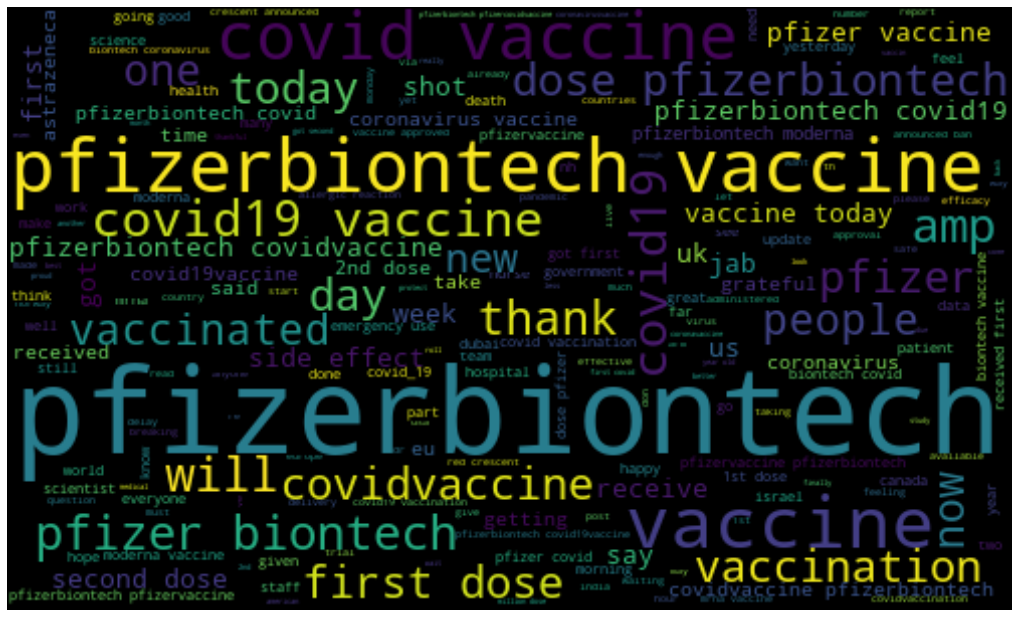

In [ ]:
# Word cloud visualization

df_pos = df_no_tags[df_no_tags['sentiment']=='positive']

from wordcloud import WordCloud

allWords = ' '.join([twts for twts in df['text']]).lower()


wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (18,18))

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

El hecho de que agreguemos comentarios más neutrales a nuestro clasificador ya muestra los impactos en nuestra nube de palabras.
Vemos las palabras como los nombres de la vacuna o la enfermedad con más frecuencia que la positiva.

#### Negativa

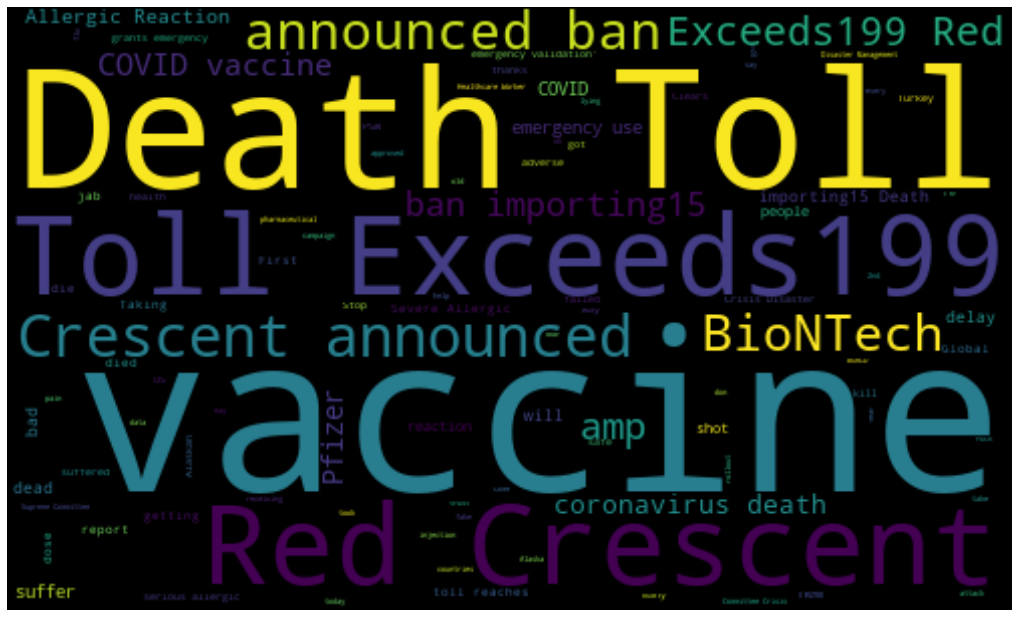

In [ ]:
# Word cloud visualization

df_neg = df_no_tags[df_no_tags['sentiment']=='negative']

from wordcloud import WordCloud

allWords = ' '.join([twts for twts in df_neg['text']])

wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (18,18))

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

En el caso de las palabras negativas, algunas palabras como Death Toll parecen aumentar. Pero recordemos que se insertaron comentarios menos neutrales en esta sección negativa.

## Conclusiones



*   No hay pruebas suficientes para saber si, de hecho, las personas están en contra o a favor de la vacuna.
*   Las palabras negativas parecen ser muy extremas en comparación con las palabras positivas.
*   La posición neutral frente a la vacuna es la más común, tal vez porque es demasiado pronto para contar el impacto de la vacuna para que la gente pueda tomar una posición.



